# Data Uploading

### importing used libraries

In [37]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Setting max number of rows and columns to be shown

In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importing data, Dropping unwanted columns

In [39]:
test0 = pd.read_csv("test.csv")
test_id = test0['Id']
test0.drop(columns=["Id"],inplace=True)

In [40]:
train0 = pd.read_csv("train.csv")
sale_prices = train0["SalePrice"]
train0.drop(columns=["Id", "SalePrice"],inplace=True)

# Linear Regression Model

In [41]:
class Linear_Regression():
    
    def __init__(self):
        self.weights = None
        
    def train(self,data_X,data_y): 
        self.weights  = np.array((np.linalg.inv(data_X.T@data_X).dot(data_X.T@data_y).T).reshape(-1))
        np.set_printoptions(suppress=True)
        
    def predict(self,x_to_predict):
        y_predicted = x_to_predict @ self.weights
        return y_predicted

# Mean Absolute Error function

In [42]:
def MAE(actual, predicted, size):
    sum_values =0
    for i in range(size) :
        sum_values += abs(actual[i] - predicted[i])
    error = sum_values/size
    print(str(error))

# Data Cleaning

### Creating a copy of training Dataframe

In [43]:
data = train0.copy()

### Checking for categorical with numerical values

In [44]:
#we need to convert columns that take numerical values although it's categorical to string so that it take definite values

data['MSSubClass'] = data['MSSubClass'].astype(str)

In [45]:
data.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

### Filling Categorical missing values

In [46]:
# searching for columns with missing data with type object (categorical)

data.select_dtypes('object').loc[:, data.isna().sum() >0].columns

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [47]:
# we define which option our column will take from the data description of missing columns

# fisrt option is to fill categorical using column mode (N/A means missing value)
for column in ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional',
    'SaleType']:
    data[column] = data[column].fillna(data[column].mode()[0])

    
#second option is to fill categorical with its category (N/A doesn't mean missing but it's a value)
for column in ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',
    'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    data[column] = data[column].fillna("None")


In [48]:
# check to see if there is any categorical columns has missing values

data.select_dtypes('object').isna().sum().sum()

0

### Filling numerical missing values


In [49]:
# searching for numerical columns with missing data

data.select_dtypes(np.number).loc[:, data.isna().sum() >0].columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [50]:
def knn_impute(df, na_target):
    # making a copy of the passed data
    df = df.copy()
    
    # selecting columns with numeric values
    numeric_df = df.select_dtypes(np.number)
    # looking for columns with non empty values by checking if condition equal true
    # loc function is for extracting specific column
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

    # False for non empty rows and True for empty
    
    # non empty rows in given column
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    
    # non empty rows with all non empty columns in the rest of the data
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    
    # empty rows with all non empty columns in the rest of the data
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
  
    # training knn with non-empty drata
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    # getting the predicted values to fill the missing values
    y_predicted = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_predicted
    
    return df

In [51]:
# applying knn imputation to all missing value columns

for column in ['LotFrontage','GarageYrBlt', 'MasVnrArea']:
    data= knn_impute(data, column)

In [52]:
data.select_dtypes(np.number).isna().sum().sum()

0

# Feature Transformation

### Log Transform for Skewed Features

array([[<AxesSubplot:title={'center':'Skew'}>]], dtype=object)

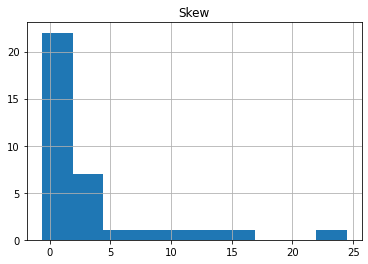

In [53]:
# creating a data frame of numerical columns with name features
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])

# defining anonymous fn with lambda to calculate the skew of each feature
# (lambda features: expression)
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))

# getting absoulte values of skew for features
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)

# mapping features to true if the skew is more than 0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

skew_df.hist('Skew')

In [54]:
# showing features that are skewed
# to get the data close to the normal disribution we can apply log transform

skew_df.query("Skewed == True")['Feature'].values

array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'], dtype=object)

In [55]:
# from this discrption of the data we can see that there are some points where the data is equals to zero
# so these point will be undefined when applying the log transform so we will apply log(x+1) instead
data[skew_df.query("Skewed == True")['Feature'].values].describe()

,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.968493,10516.828082,5.575342,1971.267808,1984.865753,104.274795,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,0.382877,1.046575,6.517808,0.613014,1977.569178,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041
std,23.745787,9981.264932,1.112799,30.202904,20.645407,181.315123,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.502885,0.220338,1.625393,0.644666,24.574083,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024
min,21.000000,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7553.500000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,9478.500000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,0.000000,1.000000,6.000000,1.000000,1978.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,81.600000,11601.500000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,1.000000,1.000000,7.000000,1.000000,2001.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,2.000000,3.000000,14.000000,3.000000,2010.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


In [56]:
# applying log(x+1) for all skewed features
for column in skew_df.query("Skewed == True")['Feature'].values:
    data[column] = np.log1p(data[column])

array([[<AxesSubplot:title={'center':'Skew'}>]], dtype=object)

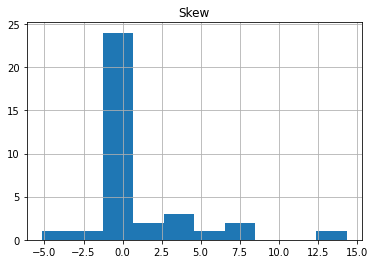

In [57]:
# creating a data frame of numerical columns with name features
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])

# defining anonymous fn with lambda to calculate the skew of each feature
# (lambda features: expression)
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))

# getting absoulte values of skew for features
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)

# mapping features to true if the skew is more than 0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

skew_df.hist('Skew')

### Replace categorical data (strings) with numerical values


In [58]:
categorical_type = 'object'

for column in data.columns:
    #  unique function returns unique values in each column.
        uniques = np.unique(data[column].values)
    # enumerate returns (index, item replaced by index)
        for idx,item in enumerate(uniques):
            data[column] = data[column].replace(item,idx) #replace(old, new)
            
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,9,3,71.0,327.0,1,1,3,3,0,4,0,5,2,2,0,5,6,4.0,104.0,53.0,1,1,12,13,1,131.0,2,4,2,2,4,3,2,361.0,6,0.0,73.0,179.0,1,0,1,4,134.0,232.0,0.0,531.0,1.0,0.0,2,1.0,3,1.0,2,6.0,6,0.0,3,1,146.0,2,2,220,5,5,2,0.0,49.0,0.0,0.0,0.0,0.0,3,4,1,0.0,1,2,8,4
1,4,3,130.0,498.0,1,1,3,3,0,2,0,24,1,2,0,2,5,7.0,77.0,26.0,1,1,8,8,2,0.0,3,4,1,2,4,1,0,482.0,6,0.0,167.0,441.0,1,0,1,4,427.0,0.0,0.0,259.0,0.0,1.0,2,0.0,3,1.0,3,4.0,6,1.0,5,1,110.0,2,2,149,5,5,2,187.0,0.0,0.0,0.0,0.0,0.0,3,4,1,0.0,4,1,8,4
2,9,3,81.0,702.0,1,1,0,3,0,4,0,5,2,2,0,5,6,4.0,102.0,52.0,1,1,12,13,1,107.0,2,4,2,2,4,2,2,222.0,6,0.0,278.0,214.0,1,0,1,4,178.0,239.0,0.0,570.0,1.0,0.0,2,1.0,3,1.0,2,4.0,6,1.0,5,1,144.0,2,2,260,5,5,2,0.0,30.0,0.0,0.0,0.0,0.0,3,4,1,0.0,8,2,8,4
3,10,3,54.0,489.0,1,1,0,3,0,0,0,6,2,2,0,5,6,4.0,19.0,20.0,1,1,13,15,2,0.0,3,4,0,4,1,3,0,66.0,6,0.0,346.0,117.0,1,2,1,4,208.0,180.0,0.0,536.0,1.0,0.0,1,0.0,3,1.0,2,5.0,6,1.0,2,5,140.0,3,3,284,5,5,2,0.0,24.0,108.0,0.0,0.0,0.0,3,4,1,0.0,1,0,8,0
4,9,3,143.0,925.0,1,1,0,3,0,2,0,15,2,2,0,5,7,4.0,101.0,50.0,1,1,12,13,1,225.0,2,4,2,2,4,0,2,328.0,6,0.0,318.0,370.0,1,0,1,4,347.0,320.0,0.0,734.0,1.0,0.0,2,1.0,4,1.0,2,7.0,6,1.0,5,1,143.0,2,3,380,5,5,2,118.0,70.0,0.0,0.0,0.0,0.0,3,4,1,0.0,11,2,8,4


### Data Scaling

In [59]:
scaler = StandardScaler()
scaler.fit(data)

data= pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

# Spilliting Data

### Adding Bias and SalePrice to training dataset

In [60]:
train_final = data.copy()

train_final["SalePrice"] = sale_prices.values

train_final["bias"] = np.ones(train_final.shape[0])

train_final.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,bias
0,0.786430,-0.045532,-0.430818,-0.549214,0.064238,0.024699,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,1.075659,0.878668,-0.491516,-0.125797,0.743092,0.751626,-1.241449,0.780257,-0.777976,0.364207,0.835599,-0.566939,0.325405,0.591905,-0.510942,0.780455,0.344051,-0.305161,-1.107210,-0.617298,-0.123046,-0.884658,0.263813,0.302403,-0.944979,1.212580,-0.114601,0.621983,1.107810,-0.241061,0.789741,1.227585,0.165410,-0.211454,-0.409369,0.914289,0.255978,-0.951226,-0.075117,-0.768736,0.981098,0.103495,0.311725,0.443881,0.315602,0.295349,0.289745,-0.749038,0.279117,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,-1.599111,0.138777,0.313867,0.208502,208500,1.0
1,-0.625160,-0.045532,0.587894,0.019617,0.064238,0.024699,0.750731,0.314667,-0.02618,-0.628316,-0.225716,1.954302,-1.188074,-0.03174,-0.411691,-0.543457,-0.071836,2.179628,0.139539,-0.429577,-0.491516,-0.125797,-0.508251,-0.661060,0.387047,-0.654142,0.663451,0.364207,-0.549162,-0.566939,0.325405,-1.124444,-1.399536,1.379426,0.344051,-0.305161,-0.692577,0.703496,-0.123046,-0.884658,0.263813,0.302403,0.473702,-0.700563,-0.114601,-0.534918,-0.819964,3.948809,0.789741,-0.761621,0.165410,-0.211454,0.795629,-0.318840,0.255978,0.600495,1.638498,-0.768736,0.130418,0.103495,0.311725,-0.166367,0.315602,0.295349,0.289745,1.845840,-0.744360,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,-0.489110,-0.614439,0.313867,0.208502,181500,1.0
2,0.786430,-0.045532,-0.258155,0.698223,0.064238,0.024699,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,1.006316,0.830215,-0.491516,-0.125797,0.743092,0.751626,-1.241449,0.517466,-0.777976,0.364207,0.835599,-0.566939,0.325405,-0.266269,-0.510942,0.092382,0.344051,-0.305161,-0.202957,-0.440856,-0.123046,-0.884658,0.263813,0.302403,-0.731935,1.270304,-0.114601,0.787863,1.107810,-0.241061,0.789741,1.227585,0.165410,-0.211454,-0.409369,-0.318840,0.255978,0.600495,1.638498,-0.768736,0.933838,0.103495,0.311725,0.787683,0.315602,0.295349,0.289745,-0.749038,-0.117741,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,0.990891,0.138777,0.313867,0.208502,223500,1.0
3,1.068748,-0.045532,-0.724346,-0.010321,0.064238,0.024699,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-1.039872,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,-1.871384,-0.720298,-0.491516,-0.125797,1.055928,1.316701,0.387047,-0.654142,0.663451,0.364207,-1.933923,0.997770,-2.834848,0.591905,-1.399536,-0.679845,0.344051,-0.305161,0.096990,-0.929853,-0.123046,0.265476,0.263813,0.302403,-0.586678,0.783772,-0.114601,0.643250,1.107810,-0.241061,-1.026041,-0.761621,0.165410,-0.211454,-0.409369,0.297725,0.255978,0.600495,-0.931925,1.301075,0.839318,0.942959,1.650307,0.993964,0.315602,0.295349,0.289745,-0.749038,-0.243065,4.284008,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,-1.599111,-1.367655,0.313867,-3.426284,140000,1.0
4,0.786430,-0.045532,0.812357,1.440032,0.064238,0.024699,-1.378933,0.314667,-0.02618,-0.628316,-

### splitting training data into training and validation for testting

In [61]:
# returning all rows in random order and resetting all indeces
train_final = train_final.sample(frac=1).reset_index(drop=True)

# training data from the top of rows until before the last 100 rows
training_data = train_final[:-100]

# validation data takes the last 100 rows
validation_data = train_final[-100:]

# training input (x) and output (y)
training_y = training_data["SalePrice"].values
training_X = training_data.drop(columns=["SalePrice"]).values

# validation input and output data
validation_y = validation_data["SalePrice"].values
validation_X = validation_data.drop(columns=["SalePrice"]).values

training_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,bias
0,0.786430,-0.045532,-0.120025,-0.419481,0.064238,0.024699,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,-0.071836,-0.517200,0.902303,0.636400,-0.491516,-0.125797,0.743092,0.751626,-1.241449,0.145180,0.663451,0.364207,0.835599,-0.566939,0.325405,0.591905,-0.510942,0.141883,0.344051,-0.305161,-0.635234,-0.783658,-0.123046,-0.884658,0.263813,0.302403,-1.109604,1.344521,-0.114601,0.532664,-0.819964,-0.241061,0.789741,1.227585,0.165410,-0.211454,-0.409369,0.297725,0.255978,-0.951226,-0.075117,-0.768736,0.839318,0.103495,0.311725,0.280575,0.315602,0.295349,0.289745,-0.749038,0.592427,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,-0.119110,1.645210,0.313867,0.208502,200500,1.0
1,0.786430,-0.045532,0.829623,0.954363,0.064238,0.024699,-1.378933,0.314667,-0.02618,0.604670,-0.225716,0.290872,-0.036289,-0.03174,-0.411691,1.026689,-0.071836,0.381743,0.139539,-0.429577,-0.491516,-0.125797,-0.195415,-0.095985,-1.241449,1.546729,0.663451,0.364207,-0.549162,0.997770,0.325405,0.591905,-0.066645,-0.813499,0.344051,-0.305161,0.463102,-0.642504,-0.123046,1.415610,0.263813,0.302403,-0.020174,1.517694,-0.114601,1.259981,-0.819964,-0.241061,0.789741,1.227585,1.397548,-0.211454,-0.409369,0.914289,0.255978,0.600495,1.638498,-0.768736,0.130418,-1.575431,0.311725,0.461071,0.315602,0.295349,0.289745,-0.749038,2.681157,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,-0.119110,-0.614439,0.313867,0.208502,195000,1.0
2,-0.625160,-0.045532,0.035372,0.172636,0.064238,0.024699,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-0.041814,-0.036289,-0.03174,-0.411691,-0.543457,-0.795151,1.280685,-0.449869,1.024029,-0.491516,-0.125797,-1.133923,-1.226134,-1.241449,-0.358502,-0.777976,0.364207,-0.549162,0.997770,0.325405,0.591905,-1.399536,1.027964,0.344051,-0.305161,-0.798440,0.027975,-0.123046,-0.884658,0.263813,0.302403,-0.262269,-0.700563,-0.114601,-1.075090,1.107810,-0.241061,-1.026041,1.227585,0.165410,-0.211454,-0.409369,-0.935404,0.255978,-0.951226,-0.075117,-0.768736,-0.814782,0.103495,-1.026858,-0.948516,0.315602,0.295349,0.289745,-0.749038,-0.744360,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,-1.390058,-0.185975,-0.162018,0.620891,0.138777,0.313867,0.208502,145500,1.0
3,1.068748,1.537245,-0.724346,-1.108066,0.064238,0.024699,0.750731,0.314667,-0.02618,-1.861302,-0.225716,0.789901,-0.036289,-0.03174,-0.411691,1.026689,-0.795151,-1.416142,-2.322108,-0.962566,-0.491516,-0.125797,1.055928,1.034163,0.387047,-0.654142,0.663451,0.364207,3.605121,0.997770,0.325405,0.591905,1.266247,-1.006556,0.344051,-0.305161,1.173272,-0.148467,-0.123046,1.415610,-3.790570,0.302403,0.783584,1.806314,-0.114601,1.655539,-0.819964,-0.241061,0.789741,-0.761621,1.397548,4.328579,0.795629,2.763982,-2.807361,-0.951226,-0.075117,-0.768736,0.437608,0.103495,-1.026858,-0.372648,0.315602,0.295349,0.289745,-0.749038,3.182452,-0.352247,-0.114517,-0.255029,-0.062051,0.063305,0.457447,-0.185975,-0.162018,2.100892,0.891994,0.313867,0.208502,107500,1.0
4,-1.754433,-0.045532,-1.104205,-1.051515,0.064238,0.024699,-1.378933,0.314667,-0.02618,0.604

In [62]:
validation_y

array([381000, 198900, 149000, 193000, 135000, 104900, 165000, 124000,
       290000, 207500,  79000, 325624, 157000, 162000, 230500, 157000,
       115000,  93500, 317000,  83000, 165500, 148500, 239000, 109900,
       132000, 267000, 190000, 125000, 190000, 111000, 342643, 181900,
       153500, 275500,  37900, 134000, 148000, 280000, 178000, 279500,
        85500, 140000, 208900, 465000, 180500, 133000, 415298, 137500,
       197000, 277000, 143900, 168000, 139400, 172000, 135750, 177000,
       201000, 194201, 107000, 120000, 169990, 179900, 200624, 125000,
       221500,  99500, 142953, 150500, 206900, 116000,  92000, 286000,
       117500,  39300, 192500, 139000, 159500, 280000, 263000, 120000,
       350000, 230000, 174000, 143000, 219500, 161500, 107500, 136000,
       306000, 170000, 157500, 152000, 124000, 184100,  82000, 153000,
       239000, 423000, 160000, 314813], dtype=int64)

In [63]:
LR_regressor = Linear_Regression()
LR_regressor.train(training_X,training_y)

predicted_values =LR_regressor.predict(validation_X)

MAE(validation_y, predicted_values, validation_y.shape[0])


17326.431665887194


In [64]:
predicted_values

array([326455.98167193, 183098.70645533, 130917.10030368, 173571.10993414,
       127757.18809943, 113303.60244721, 184777.79089939, 134315.8914839 ,
       294115.90768599, 219047.39631735,  73033.91462442, 317817.75290161,
       171526.43959368, 145065.78936184, 223381.00456028, 159933.53353641,
       110960.02457751,  63710.94989104, 293275.95987365,  92454.50490198,
       176350.67117688, 131318.51356917, 262216.88119018, 122246.85696258,
       132815.48705347, 275137.94122467, 178045.3098684 , 161297.95904697,
       227093.62080447,  81878.75770189, 318287.72764738, 187495.01859404,
       151989.34211673, 275992.05315105,  44543.13528904, 120837.20139449,
       128878.41301177, 289683.86529763, 186345.17062775, 247124.63958179,
        88888.22941378, 155807.18698547, 192867.59875289, 377130.02296542,
       183815.01476105, 125154.55263393, 350259.63243178, 120765.14114014,
       182428.21051371, 266992.94924518, 137250.29872448, 168021.38946707,
       117399.61102876, 1

In [65]:
reg = LinearRegression().fit(training_X,training_y)
reg_predction = reg.predict(validation_X)

MAE(validation_y, reg_predction, validation_y.shape[0])

17326.43166588717


In [66]:
reg_predction

array([326455.98167193, 183098.70645533, 130917.10030368, 173571.10993414,
       127757.18809943, 113303.60244721, 184777.79089939, 134315.8914839 ,
       294115.90768599, 219047.39631735,  73033.91462442, 317817.75290161,
       171526.43959368, 145065.78936184, 223381.00456028, 159933.53353641,
       110960.02457751,  63710.94989104, 293275.95987365,  92454.50490197,
       176350.67117688, 131318.51356917, 262216.88119018, 122246.85696258,
       132815.48705347, 275137.94122466, 178045.3098684 , 161297.95904698,
       227093.62080447,  81878.75770189, 318287.72764738, 187495.01859404,
       151989.34211673, 275992.05315105,  44543.13528905, 120837.20139449,
       128878.41301177, 289683.86529763, 186345.17062775, 247124.63958179,
        88888.22941378, 155807.18698547, 192867.59875289, 377130.02296542,
       183815.01476106, 125154.55263393, 350259.63243178, 120765.14114014,
       182428.21051371, 266992.94924518, 137250.29872448, 168021.38946707,
       117399.61102876, 1